In [1]:
import numpy as np
import pandas as pd

from star import star_vars
from itertools import combinations, chain, repeat

In [2]:
param_names = ['x1', 'x2', 'x3']
ivars_scales = [0.1, 0.3, 0.5]

In [3]:
def ishigami(x, a=7, b=0.1):
    '''Ishigami test function'''
    # check whether the input x is a dataframe
    
    if not isinstance(x, (pd.core.frame.DataFrame, pd.core.series.Series, np.ndarray, list)):
        raise TypeError('`x` must be of type pandas.DataFrame, numpy.ndarray, pd.Series, or list')
    
    if x.shape[0] > 3:
        raise ValueError('`x` must have only three arguments at a time')
    
    return np.sin(x[0]) + a*(np.sin(x[1])**2) + b*(x[2]**4)*np.sin(x[0])

In [4]:
def factor_ranking(factors):
    # gather indices for sorting factor
    temp = np.argsort(factors)[::-1]
    # create an array the same shape and type as temp
    ranks = np.empty_like(temp)
    # rank factors
    ranks[temp] = np.arange(len(factors))

    return ranks
    

In [5]:
# helper functions
def apply_unique(func, df, axis=1, *args, **kwargs):
    '''Apply a function to unique rows of a DataFrame
    for efficiency.'''

    applied_df = df.merge(df.drop_duplicates()
                         .assign(**{func.__name__: lambda x: x.apply(func, axis=axis)}), 
                         how='left')
    applied_df.index = df.index
    
    return applied_df
    
    
def scale(df, bounds, axis=1, *args, **kwargs):
    '''scale the sampled matrix
    bounds is a dict with ['ub', 'lb'] keys
    the values are lists of the upper and lower bounds
    of the parameters/variables/factors'''
    
    # numpy equivalent for math operations
    bounds_np = {key:np.array(value) for key,value in bounds.items()}
    
    if axis:
        return df * (bounds_np['ub'] - bounds_np['lb']) + bounds_np['lb']
    else:
        return df.T * (bounds_np['ub'] - bounds_np['lb']) + bounds_np['lb']
    
    
def pairs_h(iterable):
    '''gives the pairs of numbers considering their differences'''
    interval = range(min(iterable), max(iterable)-min(iterable))
    pairs  = {key+1:[j for j in combinations(iterable, 2) if np.abs(j[0]-j[1])==key+1] for key in interval}
    return pairs
    
    
def section_df(df, delta_h): # ***delta_h here is newly added*** July 6th, 2021 - Saman's comment
    '''gets the paired values of each section based on index'''
    pairs = pairs_h(df.index.get_level_values(-1))
    df_values = df.to_numpy()
    sample = pd.concat({h*delta_h:
                    pd.DataFrame.from_dict({str(idx_tup): [df_values[idx_tup[0]], df_values[idx_tup[1]]] for idx_tup in idx}, 'index') \
                      for h, idx in pairs.items()}) 

    return sample
    
    
# lambda functions
'''covariogram of each section'''
cov_section = lambda pair_cols, mu_star: (pair_cols.sub(mu_star, axis=0)[0] * pair_cols.sub(mu_star, axis=0)[1]).groupby(level=[0,1,2]).mean()

'''variogram over all sections'''
variogram = lambda pair_cols: 0.5*(pair_cols[0] - pair_cols[1]).pow(2).groupby(level=[1,2]).mean()

'''morris sensitivity measure equivalent evaluated over all sections'''
morris_eq = lambda pair_cols: ((pair_cols[1] - pair_cols[0]).abs().groupby(level=[1,2]).mean(), \
                               (pair_cols[1] - pair_cols[0]).groupby(level=[1,2]).mean())

'''covariogram over all sections'''
covariogram = lambda pair_cols, mu_overall: ((pair_cols - mu_overall)[0] * (pair_cols - mu_overall)[1]).groupby(level=[1,2]).mean()

'''expected covariogram over all sections'''
e_covariogram = lambda cov_section_all: cov_section_all.groupby(level=[1,2]).mean()

'''sobol (total order) sensitivity measure equivalent evaluated over all sections''' # new sobol added *** 6 July 2021
# sobol_eq = lambda gamma, ecov, variance: ((gamma + ecov) / variance).loc[:,1]
sobol_eq = lambda gamma, ecov, variance, delta_h: ((gamma + ecov) / variance)[:, delta_h] # new July 6, 2021



# ivars function
def ivars(variogram_array, scale, delta_h):
    '''generate Integrated Variogram Across a Range of Scales (IVARS)
    by approximating area using right trapezoids having width of `delta_h`
    and hights of variogram values'''
    num_h  = len(variogram_value.index.levels[-1].to_list())
    x_bench= np.arange(start=0, stop=delta_h*(num_h+1), step=delta_h)
    x_int  = np.arange(start=0, stop=(scale*10+1)/10, step=delta_h)

    # calculate interpolated values for both x (h) and y (variogram)
    if x_int[-1] < scale:
        x_int.append(scale)
    y_bench= [0] + variogram_array.to_list()

    y_int  = np.interp(x=x_int, xp=x_bench, fp=y_bench)
    
    # for loop for each step size to caluclate the area
    ivars = 0
    for i in range(len(x_int)-1):
        ivars += 0.5*(y_int[i+1] + y_int[i]) * (x_int[i+1] - x_int[i])

    return ivars

# alias
idx = pd.IndexSlice

In [6]:
delta_h = 0.05
rng = np.random.default_rng(seed=123456789)
star_centres = rng.random((10, 3))
star_points  = star_vars(star_centres, delta_h=delta_h, parameters=['x1', 'x2', 'x3'], rettype='DataFrame')
star_points

0        1         2
0 x1 0   0.027713  0.90670  0.881394
     1   0.077713  0.90670  0.881394
     2   0.127713  0.90670  0.881394
     3   0.177713  0.90670  0.881394
     4   0.227713  0.90670  0.881394
...           ...      ...       ...
9 x3 15  0.630711  0.96555  0.797082
     16  0.630711  0.96555  0.847082
     17  0.630711  0.96555  0.897082
     18  0.630711  0.96555  0.947082
     19  0.630711  0.96555  0.997082

[600 rows x 3 columns]

In [7]:
bounds = {'ub':[3.14,3.14,3.14], 'lb':[-3.13,-3.14,-3.14]}
star_points_scaled = scale(star_points, bounds)
star_points.index.names=['centre', 'param', 'points']
star_points = star_points_scaled
x = {"x1" : [-4, 0],
    "x2" : [-5, 2],
    "x3" : [0, 2]}
star_points.columns = param_names
star_points
#np.array(star_centres).shape

x1        x2        x3
centre param points                              
0      x1    0      -2.956241  2.554076  2.395152
             1      -2.642741  2.554076  2.395152
             2      -2.329241  2.554076  2.395152
             3      -2.015741  2.554076  2.395152
             4      -1.702241  2.554076  2.395152
...                       ...       ...       ...
9      x3    15      0.824555  2.923653  1.865676
             16      0.824555  2.923653  2.179676
             17      0.824555  2.923653  2.493676
             18      0.824555  2.923653  2.807676
             19      0.824555  2.923653  3.121676

[600 rows x 3 columns]

In [8]:
from tqdm.autonotebook import tqdm

def apply_unique(func, df, axis=1, *args, **kwargs):
    '''Apply a function to unique rows of a DataFrame
    for efficiency.'''
    
    tqdm.pandas(desc=func.__name__ + ' evaluation')

    applied_df = df.merge(df.drop_duplicates()
                         .assign(**{func.__name__: lambda x: x.progress_apply(func, axis=axis)}), 
                         how='left')
    applied_df.index = df.index
    
    return applied_df

<ipython-input-8-2b471e26cf18>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [9]:
# df = apply_unique(ishigami, star_points_scaled, axis=1)
df = apply_unique(ishigami, star_points, axis=1)
df.index.names=['centre', 'param', 'points']
df

ishigami evaluation:   0%|          | 0/580 [00:00<?, ?it/s]

x1        x2        x3  ishigami
centre param points                                        
0      x1    0      -2.956241  2.554076  2.395152  1.359902
             1      -2.642741  2.554076  2.395152  0.097801
             2      -2.329241  2.554076  2.395152 -0.964183
             3      -2.015741  2.554076  2.395152 -1.722528
             4      -1.702241  2.554076  2.395152 -2.103310
...                       ...       ...       ...       ...
9      x3    15      0.824555  2.923653  1.865676  1.951081
             16      0.824555  2.923653  2.179676  2.718829
             17      0.824555  2.923653  2.493676  3.900735
             18      0.824555  2.923653  2.807676  5.624277
             19      0.824555  2.923653  3.121676  8.034066

[600 rows x 4 columns]

In [10]:
# getting the paired values of each section based on `h`
tqdm.pandas(desc='building pairs')

pair_df = df[ishigami.__name__].groupby(level=[0,1]).progress_apply(section_df, delta_h=delta_h)
pair_df.index.names = ['centre', 'param', 'h', 'pair_ind']
pair_df

building pairs:   0%|          | 0/30 [00:00<?, ?it/s]

0         1
centre param h    pair_ind                    
0      x1    0.05 (0, 1)    1.359902  0.097801
                  (1, 2)    0.097801 -0.964183
                  (2, 3)   -0.964183 -1.722528
                  (3, 4)   -1.722528 -2.103310
                  (4, 5)   -2.103310 -2.069411
...                              ...       ...
9      x3    0.85 (1, 18)   4.071355  5.624277
                  (2, 19)   2.833133  8.034066
             0.90 (0, 18)   5.867209  5.624277
                  (1, 19)   4.071355  8.034066
             0.95 (0, 19)   5.867209  8.034066

[5700 rows x 2 columns]

In [11]:
vars_pbar = tqdm( desc='VARS Analysis', total=10, )

VARS Analysis:   0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
# mu_star calculation

vars_pbar.update(1)
vars_pbar.write('Averages of model runs (`mu_star`) calculated - access via .mu_star_df')


mu_star_df = df[ishigami.__name__].groupby(level=[0,1]).mean()
mu_star_df.index.names = ['centre', 'param']
mu_star_df.unstack(level=1)

Averages of model runs (`mu_star`) calculated - access via .mu_star_df


param,x1,x2,x3
centre,,,
0,2.150904,2.710954,1.610502
1,6.554998,5.454949,8.631068
2,0.220159,10.038500,2.693402
3,0.244949,5.375169,1.211887
4,0.776043,2.507499,-2.131612
5,6.467296,3.292207,6.081250
6,2.758325,4.449387,4.523496
7,6.975012,10.436840,9.864311
8,6.908376,3.255131,6.184560


In [13]:
# overall mu (mean) of the unique evaluated function values over all stars points

vars_pbar.update(1)
vars_pbar.write('Overall expected value (`mu_overall`) calculated - access via .mu_overall')

mu_overall = df[ishigami.__name__].unique().mean()
mu_overall

Overall expected value (`mu_overall`) calculated - access via .mu_overall


4.39924510466631

In [14]:
# overall var (variance) of the unique evaluated function values over all stars points

vars_pbar.update(1)
vars_pbar.write('Overall variance (`var_overall`) calculated - access via .var_overall')


var_overall = df[ishigami.__name__].unique().var(ddof=1)
var_overall

Overall variance (`var_overall`) calculated - access via .var_overall


19.251312095818722

In [15]:
# sectional covariogram calculation - content matches MATLAB code style!!

vars_pbar.update(1)
vars_pbar.write('Sectional covariogram `cov_section_all` calculated - access via .cov_section_all')


cov_section_all = cov_section(pair_df, mu_star_df)
cov_section_all.unstack(level=1)

Sectional covariogram `cov_section_all` calculated - access via .cov_section_all


param               x1         x2         x3
centre h                                    
0      0.05   9.261476   4.664341   0.141769
       0.10   8.445065   1.400862   0.079654
       0.15   6.856934  -2.409997   0.032468
       0.20   4.646802  -5.292160  -0.002699
       0.25   2.018538  -6.122015  -0.028923
...                ...        ...        ...
9      0.75 -36.149689  -6.121719  -1.593966
       0.80 -25.822936  -3.479000   0.316123
       0.85 -16.062611   1.295371   3.797793
       0.90  -8.047750   6.686244   9.574275
       0.95  -2.729299  10.898417  18.590141

[190 rows x 3 columns]

In [16]:
# variogram calculation

vars_pbar.update(1)
vars_pbar.write('Variogram (`gamma`) calculated - access via .gamma')

variogram_value = variogram(pair_df)
variogram_value.unstack(level=0)

Variogram (`gamma`) calculated - access via .gamma


param,x1,x2,x3
h,,,
0.05,0.661186,1.226571,0.342339
0.10,2.437960,4.584375,1.017255
0.15,4.984157,8.723429,1.710932
0.20,7.988032,11.717884,2.299160
0.25,11.242862,12.243790,2.761388
0.30,14.659622,10.342611,3.126330
0.35,18.218779,7.095536,3.439524
0.40,21.881268,3.712712,3.745007
0.45,25.495603,1.080355,4.075048


In [17]:
# morris calculation

vars_pbar.update(1)
vars_pbar.write('Morris MAEE and MEE (`maee` and `mee`) calculated - access via .maee and .mee')


morris_values = morris_eq(pair_df)
morris_values[0].unstack(level=0)

Morris MAEE and MEE (`maee` and `mee`) calculated - access via .maee and .mee


param,x1,x2,x3
h,,,
0.05,0.833970,1.434026,0.481342
0.10,1.597438,2.769367,0.834259
0.15,2.268394,3.810168,1.093066
0.20,2.856314,4.379065,1.286924
0.25,3.350228,4.465901,1.440368
0.30,3.793410,4.071795,1.572036
0.35,4.182681,3.357392,1.697294
0.40,4.589940,2.394522,1.823367
0.45,5.010205,1.293320,1.957726


In [18]:
morris_values[1].unstack(level=0)

param,x1,x2,x3
h,,,
0.05,0.073918,6.568686e-03,0.031610
0.10,0.298243,2.495394e-02,0.057276
0.15,0.676788,4.996015e-02,0.078048
0.20,1.201080,7.328533e-02,0.094974
0.25,1.850150,8.637015e-02,0.109103
0.30,2.591310,8.366807e-02,0.121484
0.35,3.381879,6.518158e-02,0.133165
0.40,4.171771,3.726733e-02,0.145196
0.45,4.906774,1.123546e-02,0.158626


In [19]:
# overall covariogram calculation

vars_pbar.update(1)
vars_pbar.write('Covariogram (`cov`) calculated - access via .cov')

covariogram_value = covariogram(pair_df, mu_overall)
covariogram_value.unstack(level=0)

Covariogram (`cov`) calculated - access via .cov


param,x1,x2,x3
h,,,
0.05,23.710685,17.731990,13.263374
0.10,22.319818,14.823380,12.039124
0.15,19.737566,11.061885,11.213597
0.20,16.208916,7.866853,10.699130
0.25,12.062589,6.439990,10.416038
0.30,7.678077,7.313754,10.294473
0.35,3.448135,10.154902,10.276945
0.40,-0.259547,13.895555,10.321675
0.45,-3.137707,17.139463,10.406984


In [20]:
# expected value of the overall covariogram calculation

vars_pbar.update(1)
vars_pbar.write('Expected value of covariogram (`ecov`) calculated - access via .ecov')

e_covariogram_value = e_covariogram(cov_section_all)
e_covariogram_value.unstack(level=0)

Expected value of covariogram (`ecov`) calculated - access via .ecov


param,x1,x2,x3
h,,,
0.05,14.417660,4.652049,1.860778
0.10,13.137088,1.380001,1.055793
0.15,10.655206,-2.432005,0.442841
0.20,7.206110,-5.306535,-0.015049
0.25,3.108198,-6.121890,-0.357010
0.30,-1.267953,-4.549982,-0.622473
0.35,-5.536317,-1.191011,-0.848652
0.40,-9.333094,2.650143,-1.067189
0.45,-12.351622,5.463699,-1.299762


In [21]:
# sobol calculation

vars_pbar.update(1)
vars_pbar.write('Sobol ST (`st`) calculated - access via .st')

sobol_value = sobol_eq(variogram_value, e_covariogram_value, var_overall, delta_h)
sobol_value

Sobol ST (`st`) calculated - access via .st


param
x1    0.783263
x2    0.305362
x3    0.114440
dtype: float64

In [22]:
# IVARS calculation

vars_pbar.update(1)
vars_pbar.write('IVARS (`ivars`) calculated - access via .ivars')

ivars_values = [0.1, 0.3, 0.5]
ivars_df = pd.DataFrame.from_dict({scale: variogram_value.groupby(level=0).apply(ivars, scale=scale, delta_h=delta_h) \
                      for scale in ivars_values}, 'index')
ivars_df

IVARS (`ivars`) calculated - access via .ivars


,x1,x2,x3
0.1,0.279561,0.508633,0.110753
0.3,2.554160,2.619321,0.648858
0.5,7.594296,3.068310,1.469066


In [23]:
vars_pbar.close()

In [24]:
# calculating rankings of sobol and ivars
sobol_ranking = factor_ranking(sobol_value)
sobol_ranking_df = pd.DataFrame(data=[sobol_ranking], columns=param_names, index=[''])
sobol_ranking_df

,x1,x2,x3
,0,1,2


In [25]:
ivars_ranking = []
for scale in ivars_scales:
    ivars_ranking.append(factor_ranking(ivars_df.loc[scale]))

ivars_ranking_df = pd.DataFrame(data=ivars_ranking, columns=param_names, index=ivars_scales)
ivars_ranking_df

,x1,x2,x3
0.1,1,0,2
0.3,1,0,2
0.5,0,1,2


In [35]:
pair_df
#pair_df.loc[pd.IndexSlice[8, :, :, :], :]

0         1  dissimilarity
centre param h    pair_ind                                   
0      x1    0.05 (0, 1)    1.359902  0.097801       0.796449
                  (1, 2)    0.097801 -0.964183       0.563905
                  (2, 3)   -0.964183 -1.722528       0.287543
                  (3, 4)   -1.722528 -2.103310       0.072498
                  (4, 5)   -2.103310 -2.069411       0.000575
...                              ...       ...            ...
9      x3    0.85 (1, 18)   4.071355  5.624277       1.205783
                  (2, 19)   2.833133  8.034066      13.524850
             0.90 (0, 18)   5.867209  5.624277       0.029508
                  (1, 19)   4.071355  8.034066       7.851538
             0.95 (0, 19)   5.867209  8.034066       2.347635

[5700 rows x 3 columns]

In [26]:
# bootstrapping to get CIs
bootstrap_size = 1000

# create result dataframes/series if bootstrapping is chosen to be done
result_bs_variogram = pd.DataFrame()
result_bs_sobol = pd.DataFrame()
result_bs_ivars_df = pd.DataFrame()
result_bs_sobol_ranking = pd.DataFrame()
result_bs_ivars_ranking = pd.DataFrame()

for _ in range(0, bootstrap_size):
    ## specify random sequence by sampling with replacement
    bootstrap_rand = np.random.choice(list(range(0,10)), size=len(range(0,10)), replace=True).tolist()
    bootstrapped_pairdf = pd.concat([pair_df.loc[idx[i, :, :, :], :] for i in bootstrap_rand])
    bootstrapped_df     = pd.concat([df.loc[idx[i, :, :], :] for i in bootstrap_rand])
    #display(bootstrapped_pairdf)
    #display(bootstrap_rand)

    ## calculating sectional covariograms
    bootstrapped_cov_section_all = pd.concat([cov_section_all.loc[idx[i, :]] for i in bootstrap_rand])
    #display('sectional variogram:')
    #display(bootstrapped_cov_section_all)
    #display(bootstrap_rand)

    ## calculating variogram, ecovariogram, variance, mean, Sobol, and IVARS values
    bootstrapped_variogram = variogram(bootstrapped_pairdf)
    #display('variogram:')
    #display(bootstrapped_variogram.unstack(level=0))

    bootstrapped_ecovariogram = e_covariogram(bootstrapped_cov_section_all)
    #display('E(covariogram):')
    #display(bootstrapped_ecovariogram.unstack(level=0))

    bootstrapped_var = bootstrapped_df[ishigami.__name__].unique().var(ddof=1)
    #display('variance:', bootstrapped_var)

    bootstrapped_sobol = sobol_eq(bootstrapped_variogram, bootstrapped_ecovariogram, bootstrapped_var, delta_h)
    #display('sobol:', bootstrapped_sobol)
    
    bootstrapped_sobol_ranking = factor_ranking(bootstrapped_sobol)
    bootstrapped_sobol_ranking_df = pd.DataFrame(data=[bootstrapped_sobol_ranking], columns=param_names)

    bootstrapped_ivars_df = pd.DataFrame.from_dict({scale: bootstrapped_variogram.groupby(level=0).apply(ivars, scale=scale, delta_h=delta_h) \
                                                    for scale in ivars_scales}, 'index')
    
    bootstrapped_ivars_ranking = []
    for scale in ivars_scales:
        bootstrapped_ivars_ranking.append(factor_ranking(ivars_df.loc[scale]))

    bootstrapped_ivars_ranking_df = pd.DataFrame(data=ivars_ranking, columns=param_names, index=ivars_scales)
    
    #display('ivars:', boostrapped_ivars_df)
    
    # unstack variogram
    bootstrapped_variogram_df = bootstrapped_variogram.unstack(level=0)
    
    # transpose sobol values for stacking of results
    bootstrapped_sobol_df = bootstrapped_sobol.to_frame().transpose()
    
    # attatch new results to previous results (order does not matter here)
    result_bs_variogram = pd.concat([bootstrapped_variogram_df, result_bs_variogram])
    result_bs_sobol = pd.concat([bootstrapped_sobol_df, result_bs_sobol])
    result_bs_ivars_df = pd.concat([bootstrapped_ivars_df, result_bs_ivars_df])
    result_bs_sobol_ranking = pd.concat([bootstrapped_sobol_ranking_df, result_bs_sobol_ranking])
    result_bs_ivars_ranking = pd.concat([bootstrapped_ivars_ranking_df, result_bs_ivars_ranking])

___
new bootstrapping - efficient but might result in memory leak

In [27]:
%%timeit
bootstrap_rand = np.random.choice(list(range(0,10)), size=len(range(0,10*1000)), replace=True).tolist()
b = pd.concat([pair_df.loc[idx[i, :, :, :], :] for i in bootstrap_rand])

KeyboardInterrupt: 

In [ ]:
%%timeit
# large memory usage though just below this line
a = pair_df.unstack(['param', 'h', 'pair_ind']).\
            sample(10*1000, replace=True).\
            stack(['param', 'h', 'pair_ind'])

In [ ]:
# large memory usage though just below this line
a = pair_df.unstack(['param', 'h', 'pair_ind']).\
            sample(10*1000, replace=True).\
            stack(['param', 'h', 'pair_ind'])

# this one is efficient and does not result 

num_stars = 10
num_bstrap = 1000
bstrap_index = list(chain.from_iterable(repeat(e, pair_df.shape[0]) for e in range(int(num_bstrap))))

In [ ]:
#taken from https://stackoverflow.com/a/57979836/5188208

def _handle_insert_loc(loc, n):
    """
    Computes the insert index from the right if loc is negative for a given size of n.
    """
    return n + loc + 1 if loc < 0 else loc


def add_index_level(old_index, value, name = None, loc = 0):
    """
    Expand a (multi)index by adding a level to it.

    :param old_index: The index to expand
    :param name: The name of the new index level
    :param value: Scalar or list-like, the values of the new index level
    :param loc: Where to insert the level in the index, 0 is at the front, negative values count back from the rear end
    :return: A new multi-index with the new level added
    """
    loc = _handle_insert_loc(loc, len(old_index.names))
    old_index_df = old_index.to_frame()
    old_index_df.insert(loc, name, value)
    new_index_names = list(old_index.names)  # sometimes new index level names are invented when converting to a df,
    new_index_names.insert(loc, name)        # here the original names are reconstructed
    new_index = pd.MultiIndex.from_frame(old_index_df, names=new_index_names)
    return new_index

In [ ]:
a.index = add_index_level(a.index, bstrap_index, 'bootstrap', loc=0)
d = a.groupby('bootstrap')

In [ ]:
d.apply(variogram)

In [28]:
# calculate upper and lower confidence interval limits of the ivars values
ivars_low = pd.DataFrame()
ivars_upp = pd.DataFrame()
for scale in ivars_scales:
    ivars_low = pd.concat([ivars_low, result_bs_ivars_df.loc[scale].quantile((1-0.9)/2).rename(scale).to_frame()], axis=1)
    ivars_upp = pd.concat([ivars_upp, result_bs_ivars_df.loc[scale].quantile(1-((1-0.9)/2)).rename(scale).to_frame()], axis=1)

ivars_low = ivars_low.transpose()
ivars_upp = ivars_upp.transpose()
display(ivars_low)
display(ivars_upp)

,x1,x2,x3
0.1,0.127705,0.50765,0.062549
0.3,1.166807,2.61862,0.365849
0.5,3.469106,3.06766,0.827591


,x1,x2,x3
0.1,0.466847,0.509649,0.159800
0.3,4.265819,2.620046,0.937369
0.5,12.681745,3.068939,2.121665


In [29]:
variogram_low = pd.DataFrame()
variogram_upp = pd.DataFrame()
for h in np.unique(result_bs_variogram.index.values).tolist():
    variogram_low = pd.concat([variogram_low, result_bs_variogram.loc[h].quantile((1-0.9)/2).rename(h).to_frame()], axis=1)
    variogram_upp = pd.concat([variogram_upp, result_bs_variogram.loc[h].quantile(1-((1-0.9)/2)).rename(h).to_frame()], axis=1)
    
variogram_low = variogram_low.transpose()
variogram_upp = variogram_upp.transpose()

variogram_low.index.names = ['h']
variogram_upp.index.names = ['h']

display(variogram_low)
display(variogram_upp)

param,x1,x2,x3
h,,,
0.05,0.302023,1.225091,0.193512
0.10,1.113666,4.575283,0.574601
0.15,2.276833,8.705253,0.965716
0.20,3.649129,11.701472,1.296812
0.25,5.136090,12.243626,1.556526
0.30,6.696987,10.322954,1.761305
0.35,8.322821,7.070843,1.937017
0.40,9.995680,3.698602,2.108573
0.45,11.646339,1.077721,2.294118


param,x1,x2,x3
h,,,
0.05,1.104340,1.228101,0.493603
0.10,4.071194,4.593770,1.467550
0.15,8.323611,8.742209,2.469683
0.20,13.341036,11.734842,3.320588
0.25,18.777849,12.243948,3.989338
0.30,24.484695,10.361636,4.515274
0.35,30.428105,7.119434,4.967387
0.40,36.542119,3.726369,5.409208
0.45,42.578578,1.082904,5.886283


In [30]:
sobol_low = result_bs_sobol.quantile((1-0.9)/2).rename('').to_frame().transpose()
sobol_upp = result_bs_sobol.quantile(1-((1-0.9)/2)).rename('').to_frame().transpose()
                            
display(sobol_low)
display(sobol_upp)

param,x1,x2,x3
,0.446318,0.240091,0.073599


param,x1,x2,x3
,1.204366,0.450984,0.164211


In [31]:
rel_sobol_results = []
for param in param_names:
    rel_sobol_results.append(result_bs_sobol_ranking[param].eq(sobol_ranking_df[param][0]).sum()/bootstrap_size)

rel_sobol = pd.DataFrame([rel_sobol_results],  columns=param_names, index=[''])
rel_sobol

,x1,x2,x3
,0.967,0.967,1.0


In [32]:
# small test to see if this works properly
df = pd.DataFrame({'x1' : [2], 'x2' : [0], 'x3' : [1]}, index = [0])
df
df2 = pd.DataFrame({'x1' : [1, 0, 2, 2], 'x2' : [0, 0, 0, 0], 'x3' : [0, 3, 4, 1]}, index=[0, 0, 0, 0])
df2.eq(df)['x3'].sum()

1

In [33]:
# calculate relibability estimate based on ivars factor rankings
rel_ivars_results = []
for param in param_names:
    rel_ivars_results_scale = []
    for scale in ivars_scales:
        rel_ivars_results_scale.append(result_bs_ivars_ranking[param].loc[scale].eq(ivars_ranking_df[param].loc[scale]).sum()/bootstrap_size)
    rel_ivars_results.append(rel_ivars_results_scale)

rel_ivars = pd.DataFrame(rel_ivars_results,  columns=ivars_scales, index=param_names)
# tranpose to get data in right format
rel_ivars = rel_ivars.transpose()

rel_ivars

,x1,x2,x3
0.1,1.0,1.0,1.0
0.3,1.0,1.0,1.0
0.5,1.0,1.0,1.0


In [34]:
import scipy.stats as stat
import scipy.cluster.hierarchy as hchy
import scipy.spatial.distance as dist
from matplotlib import pyplot as plt
from itertools import compress

In [35]:
def factor_grouping(sens_idx, num_grp=None):
    [m, n] = sens_idx.shape

    # make data 1d
    R = sens_idx.stack()
    # replacing zeros with a constant number due to numerical reasoning
    R[R == 0] = np.ones(len(R[R == 0]))

    # do a box-cox transformation
    [TRANSDAT, LAMBDA] = stat.boxcox(R)
    if LAMBDA <= 0.0099:
        TRANSDAT = np.log(R)

    indices = np.argwhere(np.isinf(TRANSDAT).tolist())
    if indices.shape == (2, 1):
        TRANSDAT[indices[0], indices[1]] = np.log(R[R > 0])

    # reshape data for the linkage calculation
    S = np.reshape(TRANSDAT.tolist(), [n, m])
    
    # Agglomerative hierarchical cluster
    Z = hchy.linkage(S, method='ward', metric='euclidean')
    
    # Optimal group number
    Clusters = []
    for i in range(2, n+1):
        Clusters.append(hchy.fcluster(Z, criterion='maxclust', t=i))
    # if user gives the group number preform calculations
    if num_grp:
        rank_grp = hchy.fcluster(Z, criterion='maxclust', t=num_grp)
        optm_num_grp = num_grp
        nn = 1
        id = len(Z)
        while nn != optm_num_grp:
            cutoff = Z[id-1][2]
            rank_grp = hchy.fcluster(Z, criterion='distance', t=cutoff)
            nn = np.amax(rank_grp)
            id = id - 1

        clrThrshl = 0.5*(Z[id][2] + Z[id+1][2])
    # if user does not give optimal group number use elbow method
    else:
        cutoff, clrThrshl = elbow_method(Z)
        rank_grp = hchy.fcluster(Z, criterion='distance', t=cutoff)
        optm_num_grp = max(rank_grp)
        
    
    #*** this part can be edited once we start working on plots
    #fig = plt.figure(figsize=(25,10))
    #dn = hchy.dendrogram(Z)
    #plt.show()
    
    return optm_num_grp, rank_grp, Clusters
    

In [36]:
def elbow_method(Z):
    Q1 = np.array([1, Z[0][2]])
    Q2 = np.array([len(Z), Z[-1][2]])
    
    d = []
    for i in range(0, len(Z) - 2):
        P = [i+1, Z[i][2]]
        d.append(np.abs(np.linalg.det(np.array([[Q2 - Q1], [P-Q1]])))/np.linalg.norm(Q2-Q1))
    id = d.index(max(d))
    cutoff = Z[id][2]
    clrThrshl = 0.5*(Z[id][2] + Z[id+1][2])
    
    return cutoff, clrThrshl

In [37]:
# grouping
num_grp_ivars50, ivars50_grp_array, ClustersIvars50 = factor_grouping(result_bs_ivars_df.loc[0.5], num_grp=2)
num_grp_sobol, sobol_grp_array, ClustersSobol = factor_grouping(result_bs_sobol, num_grp=2)

display(num_grp_ivars50)
display(num_grp_sobol)

display(ivars50_grp_array)
display(sobol_grp_array)

display(ClustersIvars50)
display(ClustersSobol)

2

2

array([1, 2, 1], dtype=int32)

array([1, 2, 1], dtype=int32)

[array([1, 1, 1], dtype=int32), array([1, 1, 1], dtype=int32)]

[array([1, 1, 1], dtype=int32), array([1, 1, 1], dtype=int32)]

In [38]:
# Reliability estimates of group
cluster_sobol = []
cluster_rank_sobol = []
for g in range(0, num_grp_sobol):
    cluster_sobol.append(np.argwhere(sobol_grp_array==g + 1).flatten())
    cluster_rank_sobol.append(sobol_ranking_df.to_numpy().flatten()[cluster_sobol[g]])
    cluster_rank_sobol[g] = np.sort(cluster_rank_sobol[g], axis=0)

display(cluster_sobol)
display(cluster_rank_sobol)

[array([0, 2], dtype=int64), array([1], dtype=int64)]

[array([0, 2], dtype=int64), array([1], dtype=int64)]

In [39]:
cluster_ivars50 = []
cluster_rank_ivars50 = []
for g in range(0, num_grp_ivars50):
    cluster_ivars50.append(np.argwhere(ivars50_grp_array==g + 1).flatten())
    cluster_rank_ivars50.append(ivars_ranking_df.loc[0.5].to_numpy()[cluster_ivars50[g]])
    cluster_rank_ivars50[g] = np.sort(cluster_rank_ivars50[g], axis=0)

display(cluster_ivars50)
display(cluster_rank_ivars50)

[array([0, 2], dtype=int64), array([1], dtype=int64)]

[array([0, 2], dtype=int64), array([1], dtype=int64)]

In [40]:

reli_sobol_grp_array = np.zeros(len(param_names))
reli_ivars50_grp_array = np.zeros(len(param_names))
for D in range (0, len(param_names)):
    match = [np.argwhere(cluster_sobol[x]==D).flatten() for x in range(0, len(cluster_sobol))]
    rank_range_sobol = [(match[x].size != 0) for x in range(0, len(match))]
    rank_sobol_benchmark = list(compress(cluster_rank_sobol, rank_range_sobol))
    rank_sobol_benchmark = rank_sobol_benchmark[0]
    
    match = [np.argwhere(cluster_ivars50[x]==D).flatten() for x in range(0, len(cluster_ivars50))]
    rank_range_ivars50 = [(match[x].size != 0) for x in range(0, len(match))]
    rank_ivars50_benchmark = list(compress(cluster_rank_ivars50, rank_range_ivars50))
    rank_ivars50_benchmark = rank_ivars50_benchmark[0]
    
    # calculate the reliability of paramter number D
    reli_sobol = 0
    reli_ivars50 = 0
    for i in range(0, bootstrap_size):
        reli_sobol += len(np.argwhere(result_bs_sobol_ranking.iloc[i, D] == rank_sobol_benchmark))/bootstrap_size
        reli_ivars50 += len(np.argwhere(result_bs_ivars_ranking.loc[0.5].iloc[i, D] == rank_ivars50_benchmark))/bootstrap_size
        
    reli_sobol_grp_array[D] = reli_sobol
    reli_ivars50_grp_array[D] = reli_ivars50

reli_sobol_grp = pd.DataFrame([reli_sobol_grp_array], columns=param_names, index=[''])
reli_ivars50_grp = pd.DataFrame([reli_ivars50_grp_array], columns=param_names, index=[0.5])
    
display(reli_sobol_grp)
display(reli_ivars50_grp)

,x1,x2,x3
,0.967,0.967,1.0


,x1,x2,x3
0.5,1.0,1.0,1.0


In [41]:
# change the ordering of the groups to match matlab style
numgrp = 2
for i in range(0, len(ivars50_grp_array)):
    ivars50_grp_array[i] = np.abs(ivars50_grp_array[i] - numgrp) + 1
   
for i in range(0, len(sobol_grp_array)):
    sobol_grp_array[i] = np.abs(sobol_grp_array[i] - numgrp) + 1  
    
display(ivars50_grp_array)
display(sobol_grp_array)

array([2, 1, 2], dtype=int32)

array([2, 1, 2], dtype=int32)

In [42]:
# display groups
ivars50_grps = pd.DataFrame([ivars50_grp_array], columns=param_names, index=[0.5])
sobol_grps = pd.DataFrame([sobol_grp_array], columns=param_names, index=[''])

display(ivars50_grps)
display(sobol_grps)

,x1,x2,x3
0.5,2,1,2


,x1,x2,x3
,2,1,2


In [43]:
# create a random int for the default seed
np.random.randint(1, 123456790)


52411796

<AxesSubplot:xlabel='Perturbation Scale, h', ylabel='Variogram, $\\gamma$(h)'>

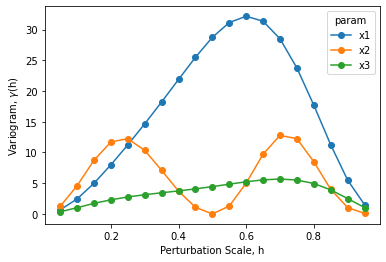

In [44]:
ymax = variogram_value.unstack(0).loc[0:0.6].max().max()
variogram_value.unstack(0).plot(xlabel='Perturbation Scale, h', ylabel='Variogram, $\gamma$(h)', marker='o')

In [45]:
# normalize data using mean normalization
df1 = morris_values[0].unstack(0).iloc[0]
df2 = sobol_value
df3 = ivars_df.loc[0.5]

normalized_maee = df1/df1.sum()
normalized_sobol = df2/df2.sum()
normalized_ivars50 = df3/df3.sum()
display(normalized_sobol)
display(normalized_ivars50)

param
x1    0.651056
x2    0.253820
x3    0.095124
dtype: float64

x1    0.625989
x2    0.252917
x3    0.121093
Name: 0.5, dtype: float64

In [46]:
# if bootstrapping is a thing compute bar chart confidence intervals
# not sure if this will be included in code
ivars50_err_upp = ivars_upp.loc[0.5]/df3.sum()
ivars50_err_low = ivars_low.loc[0.5]/df3.sum()
sobol_err_upp = (sobol_upp/df2.to_numpy().sum()).to_numpy().flatten()
sobol_err_low = (sobol_low/df2.to_numpy().sum()).to_numpy().flatten()

# subtract from normalized values so that error bars work properly
ivars50_err_upp = np.abs(ivars50_err_upp - normalized_ivars50)
ivars50_err_low = np.abs(ivars50_err_low - normalized_ivars50)
sobol_err_upp = np.abs(sobol_err_upp - normalized_sobol)
sobol_err_low = np.abs(sobol_err_low - normalized_sobol)

ivars50_err = np.array([ivars50_err_low, ivars50_err_upp])
sobol_err = np.array([sobol_err_low, sobol_err_upp])

display(ivars50_err)
display(sobol_err)

array([[3.40034782e-01, 5.35896886e-05, 5.28760581e-02],
       [4.19352700e-01, 5.18663443e-05, 5.37929904e-02]])

array([[0.28007252, 0.05425382, 0.03394753],
       [0.35002498, 0.12104285, 0.04136994]])

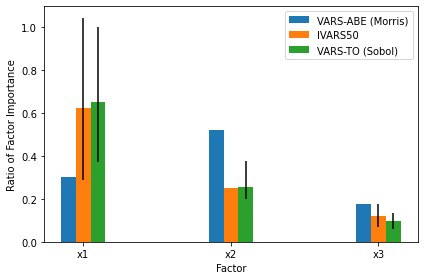

In [47]:
# create barchart
x = np.arange(len(param_names))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, normalized_maee, width, label='VARS-ABE (Morris)')
rects2 = ax.bar(x, normalized_ivars50, width, label='IVARS50', yerr=ivars50_err)
rects3 = ax.bar(x + width, normalized_sobol, width, label='VARS-TO (Sobol)', yerr=sobol_err)

# Add some text for labels, and custom x-axis tick labels, etc.
ax.set_ylabel('Ratio of Factor Importance')
ax.set_xlabel('Factor')
ax.set_xticks(x)
ax.set_xticklabels(param_names)
ax.legend()

fig.tight_layout()

plt.show()

In [65]:
bounds_np = {key:np.array(value) for key,value in bounds.items()}

In [85]:
scale(star_centres, bounds)

array([[-2.95624112,  2.55407635,  2.39515152],
       [ 0.78810592,  1.82568901,  2.04670233],
       [ 2.14749559, -0.17754849,  2.87139674],
       [ 2.80512891,  0.18751903, -2.61473997],
       [-1.43807651, -2.80213702,  0.41836412],
       [-3.01138579, -1.85025366, -1.57405167],
       [ 2.50533817, -2.463033  ,  1.56169855],
       [ 1.35119167,  1.51209263,  2.79533777],
       [-0.24918034, -1.68533239, -0.21996471],
       [ 0.82455492,  2.92365323,  3.12167608]])